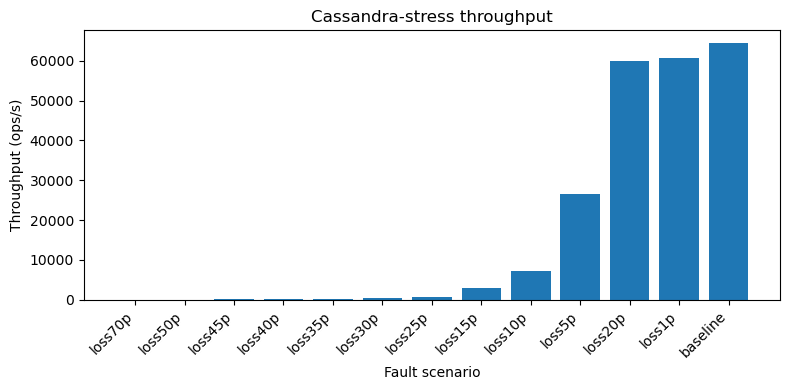

In [6]:
import os, glob, re
import pandas as pd
import matplotlib.pyplot as plt

# adjust this to where you SCP’d your logs:
BASE = r"C:\Outputs\outputs"

rows = []
for lp in glob.glob(os.path.join(BASE, "*", "*_cassandra-stress.log")):
    scenario = os.path.basename(os.path.dirname(lp)).split("_")[-1]
    txt = open(lp, encoding="utf-8", errors="ignore").read()
    m = re.search(r"Op rate\s*:\s*([\d,]+)\s*op/s", txt)
    if m:
        rate = int(m.group(1).replace(",", ""))
        rows.append((scenario, rate))

df = pd.DataFrame(rows, columns=["scenario","ops_per_s"]).sort_values("ops_per_s")

plt.figure(figsize=(8,4))
plt.bar(df["scenario"], df["ops_per_s"])
plt.xlabel("Fault scenario")
plt.ylabel("Throughput (ops/s)")
plt.title("Cassandra-stress throughput")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


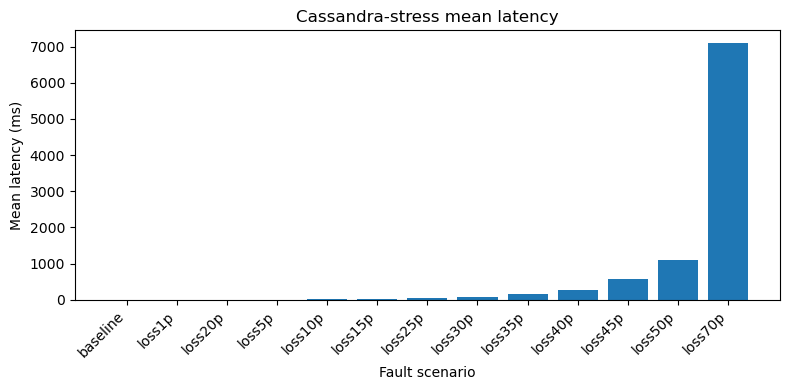

In [8]:
import os, glob, re
import pandas as pd
import matplotlib.pyplot as plt

BASE = r"C:\Outputs\outputs"

rows = []
for lp in glob.glob(os.path.join(BASE, "*", "*_cassandra-stress.log")):
    scenario = os.path.basename(os.path.dirname(lp)).split("_")[-1]
    txt = open(lp, encoding="utf-8", errors="ignore").read()
    m = re.search(r"Latency mean\s*:\s*([\d\.]+)\s*ms", txt)
    if m:
        mean_ms = float(m.group(1))
        rows.append((scenario, mean_ms))

df = pd.DataFrame(rows, columns=["scenario","mean_latency_ms"]).sort_values("mean_latency_ms")

plt.figure(figsize=(8,4))
plt.bar(df["scenario"], df["mean_latency_ms"])
plt.xlabel("Fault scenario")
plt.ylabel("Mean latency (ms)")
plt.title("Cassandra-stress mean latency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


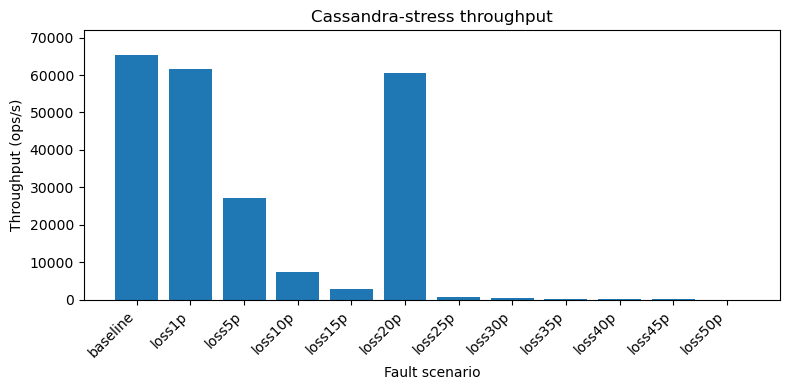

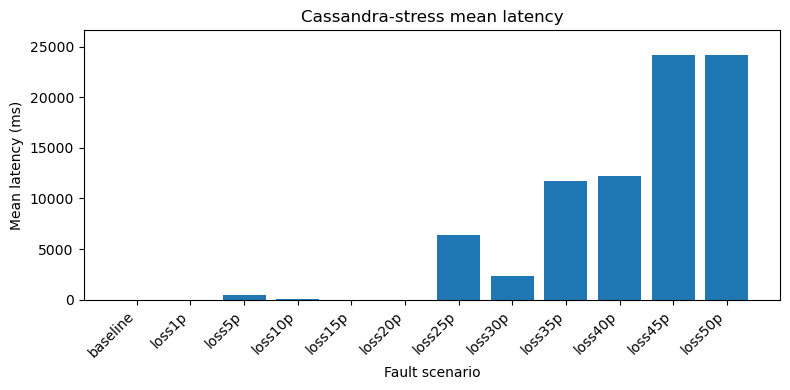

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1) Point this at your SCP’d outputs directory:
base_dir = r"C:\Outputs\outputs"
duration_s = 60.0   # your run duration in seconds

# 2) Collect last “total,” line from each stress log
data = []
for run in sorted(os.listdir(base_dir)):
    run_dir = os.path.join(base_dir, run)
    if not os.path.isdir(run_dir):
        continue

    scenario = run.split("_")[-1]
    log = os.path.join(run_dir, f"{scenario}_cassandra-stress.log")
    if not os.path.exists(log):
        continue

    # read & filter
    with open(log, "r") as f:
        total_lines = [l.strip() for l in f if l.startswith("total,")]

    if not total_lines:
        continue

    last = total_lines[-1].split(",")
    # fields: ["total", ops, p50, p75, p90, mean, ..., p95, p99, p99.9, max, ...]
    ops      = float(last[1])
    mean_lat = float(last[5])
    tp       = ops / duration_s

    data.append((scenario, tp, mean_lat))

# 3) Build DataFrame & enforce paper’s order
order = [
    "baseline","loss1p","loss5p","loss10p","loss15p","loss20p",
    "loss25p","loss30p","loss35p","loss40p","loss45p","loss50p"
]
df = (
    pd.DataFrame(data, columns=["scenario","throughput","mean_latency"])
      .set_index("scenario")
      .reindex(order)
      .dropna()
)

# 4) Throughput bar chart
plt.figure(figsize=(8,4))
plt.bar(df.index, df.throughput)
plt.title("Cassandra‑stress throughput")
plt.ylabel("Throughput (ops/s)")
plt.xlabel("Fault scenario")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, df.throughput.max() * 1.1)
plt.tight_layout()
plt.show()

# 5) Mean‑latency bar chart
plt.figure(figsize=(8,4))
plt.bar(df.index, df.mean_latency)
plt.title("Cassandra‑stress mean latency")
plt.ylabel("Mean latency (ms)")
plt.xlabel("Fault scenario")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, df.mean_latency.max() * 1.1)
plt.tight_layout()
plt.show()


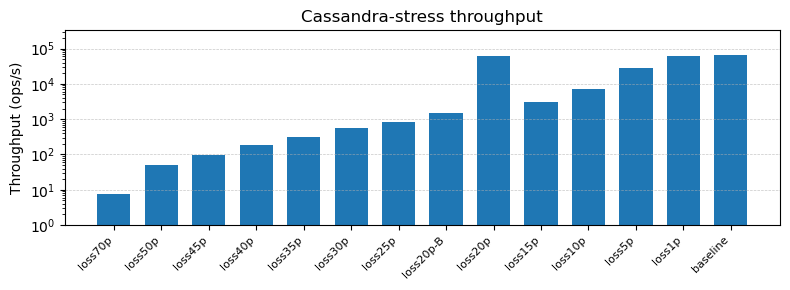

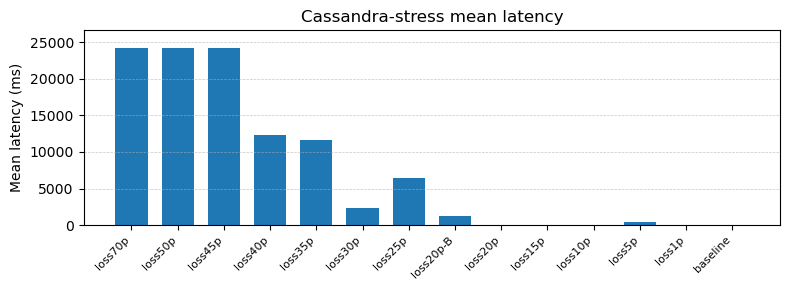

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1) Point this at your SCP’d outputs directory:
base_dir = r"C:\Outputs\outputs"

# 2) Gather data
data = []
for run in sorted(os.listdir(base_dir)):
    path = os.path.join(base_dir, run)
    if not os.path.isdir(path):
        continue
    scenario = run.split("_")[-1]
    log = os.path.join(path, f"{scenario}_cassandra-stress.log")
    if not os.path.exists(log):
        continue

    # manually parse each “total,” line and keep the last one
    with open(log, 'r') as f:
        last = None
        for line in f:
            if line.startswith("total,"):
                parts = [p.strip() for p in line.split(',')]
                last = parts
        if not last:
            continue

    total_ops = float(last[1])       # cumulative ops
    mean_lat  = float(last[5])       # mean latency (ms)
    data.append((scenario, total_ops / 60.0, mean_lat))

# 3) Build DataFrame & enforce paper ordering
order = [
    "loss70p","loss50p","loss45p","loss40p","loss35p","loss30p",
    "loss25p","loss20p-B","loss20p","loss15p","loss10p","loss5p","loss1p","baseline"
]
df = (
    pd.DataFrame(data, columns=["scenario","throughput","mean_latency"])
      .set_index("scenario")
      .reindex(order)
      .dropna()
)

# 4) Throughput bar chart (log scale)
plt.figure(figsize=(8,3))
plt.bar(df.index, df.throughput, width=0.7)
plt.yscale('log')
plt.ylim(1, df.throughput.max()*5)
plt.title("Cassandra‑stress throughput", fontsize=12)
plt.ylabel("Throughput (ops/s)", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# 5) Mean‑latency bar chart (linear)
plt.figure(figsize=(8,3))
plt.bar(df.index, df.mean_latency, width=0.7)
plt.ylim(0, df.mean_latency.max()*1.1)
plt.title("Cassandra‑stress mean latency", fontsize=12)
plt.ylabel("Mean latency (ms)", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


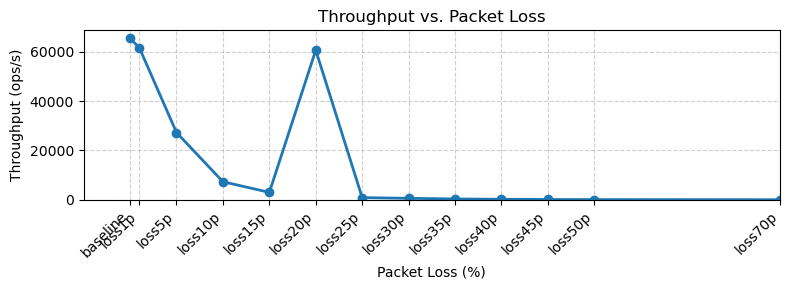

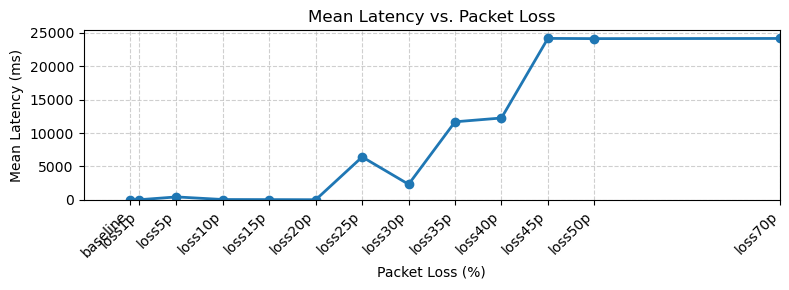

In [49]:
import matplotlib.pyplot as plt

# df.index: ["loss50p","loss45p",…,"loss1p","baseline"]
# df.throughput, df.mean_latency already defined

# Build an x‐axis in “%” (baseline→0)
loss_pcts = []
for s in df.index:
    if s == "baseline":
        loss_pcts.append(0)
    else:
        loss_pcts.append(int(s.replace("loss","").replace("p","")))

# 1) Throughput trend
plt.figure(figsize=(8,3))
plt.plot(loss_pcts, df.throughput, marker='o', linewidth=2)
plt.xlim(-5, 55)
plt.ylim(0, df.throughput.max()*1.05)
plt.title("Throughput vs. Packet Loss")
plt.xlabel("Packet Loss (%)")
plt.ylabel("Throughput (ops/s)")
plt.grid(True, linestyle='--', alpha=0.6)
# show labels at each point
plt.xticks(loss_pcts, df.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 2) Mean‑latency trend
plt.figure(figsize=(8,3))
plt.plot(loss_pcts, df.mean_latency, marker='o', linewidth=2)
plt.xlim(-5, 55)
plt.ylim(0, df.mean_latency.max()*1.05)
plt.title("Mean Latency vs. Packet Loss")
plt.xlabel("Packet Loss (%)")
plt.ylabel("Mean Latency (ms)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(loss_pcts, df.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()


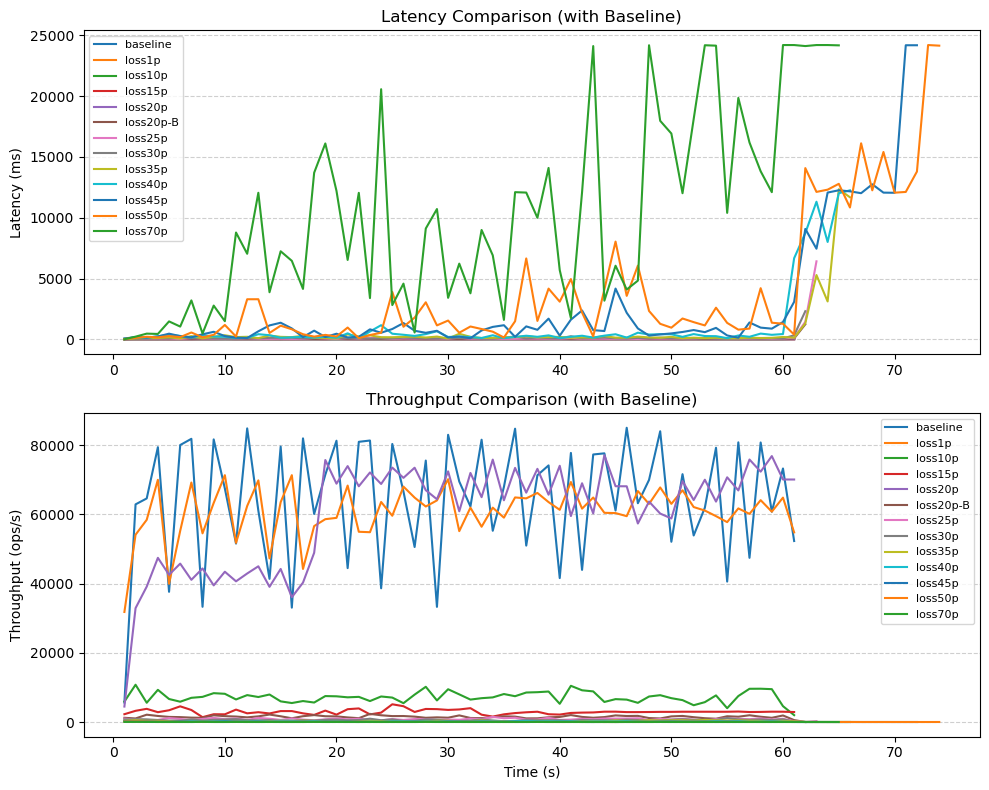

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1) Point this at your SCP’d outputs directory:
base_dir = r"C:\Outputs\outputs"

# 2) List the scenarios in the order/time‑series you want:
scenarios = [
    "baseline",
    "loss1p",
    "loss10p",
    "loss15p",
    "loss20p",
    "loss20p-B",
    "loss25p",
    "loss30p",
    "loss35p",
    "loss40p",
    "loss45p",
    "loss50p",
    "loss70p",
]

ts_data = {}
for sc in scenarios:
    # find the most recent folder ending in _<scenario>
    folders = [d for d in os.listdir(base_dir) if d.endswith(f"_{sc}")]
    if not folders:
        print(f"❌ no folder for {sc}")
        continue
    run_dir = os.path.join(base_dir, folders[-1])
    log = os.path.join(run_dir, f"{sc}_cassandra-stress.log")
    if not os.path.isfile(log):
        print(f"❌ no log for {sc}")
        continue

    times, lats, throughputs = [], [], []
    with open(log) as f:
        idx = 0
        for line in f:
            if not line.startswith("total,"):
                continue
            parts = line.strip().split(",")
            # parts[2] = ops in this 1s interval
            # parts[5] = mean latency (ms) in that interval
            ops_per_s   = float(parts[2])
            mean_lat_ms = float(parts[5])
            idx += 1
            times.append(idx)
            throughputs.append(ops_per_s)
            lats.append(mean_lat_ms)

    ts_data[sc] = pd.DataFrame({
        "time_s": times,
        "throughput": throughputs,
        "mean_lat": lats
    })

# 3) Plot
plt.figure(figsize=(10,8))

# Latency over time
plt.subplot(2,1,1)
for sc, df in ts_data.items():
    plt.plot(df.time_s, df.mean_lat, label=sc, linewidth=1.5)
plt.title("Latency Comparison (with Baseline)")
plt.ylabel("Latency (ms)")
plt.legend(fontsize=8, loc="upper left")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Throughput over time
plt.subplot(2,1,2)
for sc, df in ts_data.items():
    plt.plot(df.time_s, df.throughput, label=sc, linewidth=1.5)
plt.title("Throughput Comparison (with Baseline)")
plt.xlabel("Time (s)")
plt.ylabel("Throughput (ops/s)")
plt.legend(fontsize=8, loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
